## Import the libraries

In [677]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Import the dataset

In [678]:
dataset_filepath = '/Users/davronabdukhakimov/Desktop/RealEstate_California.csv'
raw_dataset = pd.read_csv(dataset_filepath)

# convert 'datePostedString' into column with date dtype
raw_dataset['date_posted'] = pd.to_datetime(raw_dataset['datePostedString'],format='%Y-%m-%d')

## Dealing with missing values

### Drop unnecessary columns

In [679]:
# columns which are redundant
columns_to_drop = ['Unnamed: 0','cityId','id','stateId','currency','countyId','state','country','description','time','datePostedString','hasBadGeocode','is_bankOwned','is_forAuction','lotAreaUnits']
clean_dataset = raw_dataset.drop(columns_to_drop,axis = 1)

### Drop rows with nan values, duplicates and rows with event type of rent

In [680]:
clean_dataset.dropna(inplace=True)
clean_dataset.drop_duplicates(inplace=True)

# only 4 entries for "Listed for rent"
clean_dataset = clean_dataset[clean_dataset['event'] != 'Listed for rent']

# only 1 entry for "APARTMENT"
clean_dataset.loc[clean_dataset['homeType'] == 'APARTMENT','homeType'] = 'CONDO'

# some features such as yearBuilt of lot properties are ambiguous 
clean_dataset = clean_dataset[clean_dataset['homeType'] != 'LOT']

# only 1 entry for "Pending sale"
clean_dataset = clean_dataset[clean_dataset['event'] != 'Pending sale']

In [681]:
# we keep buildingArea for now since there are only below 6k entries where livingAreaValue and buildingArea matches
clean_dataset[clean_dataset['livingAreaValue'] == clean_dataset['buildingArea']].shape

(5793, 25)

### Extract season from date_posted column

In [682]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'
    
clean_dataset['season_posted'] = clean_dataset['date_posted'].apply(get_season)
clean_dataset.drop('date_posted',axis=1,inplace=True)

### Extract street name from streetAddress column

In [683]:
split_address = clean_dataset['streetAddress'].str.split(' ',n=1,expand=True)
clean_dataset = clean_dataset[split_address[1].notna()]
clean_dataset = clean_dataset[split_address[0].str.isdigit()]
clean_dataset['street_name'] = split_address[1]
clean_dataset.drop('streetAddress',axis = 1,inplace=True)

/var/folders/r1/m92fhd0n5mq0_bh6sg3_pnlh0000gn/T/ipykernel_91291/2322718560.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_dataset = clean_dataset[split_address[0].str.isdigit()]


### Drop livingArea since the column contains the same values as livingAreaValue column

In [684]:
# there is only 1 entry where livingArea and livingAreaValue have different values
clean_dataset.drop('livingArea',axis=1,inplace=True)

### Drop hasGarage column since garageSpaces column is more informative

In [685]:
print(f"hasGarage = 1 and garageSpaces = 0: {clean_dataset[(clean_dataset['hasGarage'] == 1) & (clean_dataset['garageSpaces'] == 0)].shape[0]} entries")
print(f"hasGarage = 0 and garageSpaces != 0: {clean_dataset[(clean_dataset['hasGarage'] == 0) & (clean_dataset['garageSpaces'] != 0)].shape[0]} entries")
clean_dataset = clean_dataset[((clean_dataset['hasGarage'] == 0) & (clean_dataset['garageSpaces'] == 0)) | ((clean_dataset['hasGarage'] != 0) & (clean_dataset['garageSpaces'] != 0))]
clean_dataset.drop('hasGarage',axis=1,inplace=True)
print(clean_dataset.shape)

hasGarage = 1 and garageSpaces = 0: 878 entries
hasGarage = 0 and garageSpaces != 0: 87 entries
(24039, 23)


### Split levels column into 2 columns (level and multi/split)

In [686]:
zero_level = ['0']
one_level = ['One','One Story','One Story-One','One-Two','1','One-Multi/Split','Other-One','One-Three Or More',
             'One Story-Two','One Story-Three Or More','Multi/Split-One','One-Two-Three Or More','One-Two-Multi/Split']
two_level = ['Two','Two Story','Two Story-Two','2','Two-Multi/Split','Multi/Split-Two','Two-Three Or More','Two Story-One',
             'Two Story-Three Or More','Two-Three Or More-Multi/Split','Two-One']
three_level_more = ['Three Or More','Three or More Stories','Tri-Level','Three or More Stories-Three Or More',
                    'Three Or More-Multi/Split','3','Three','Three or More Stories-One','Three or More Stories-Two',
                   'Four','Tri-Level-Three Or More','Multi/Split-Three Or More','Multi/Split-Tri-Level','4+','Five or More',
                    'Three Or More-Split Level','Tri-Level-Two','Three Or More-Two','Three or More Stories-One-Two']


total = zero_level
total.extend(one_level)
total.extend(two_level)
total.extend(three_level_more)
missing_type = [val for val in clean_dataset['levels'].unique() if val not in total]

def get_level(level):
    if level in one_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['one', 1]
        else:
            return ['one', 0]
    elif level in two_level:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['two', 1]
        else:
            return ['two', 0]
    elif level in three_level_more:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['three+', 1]
        else:
            return ['three+', 0]
    else:
        if 'split' in level.lower() or 'multi' in level.lower():
            return ['zero', 1]
        else:
            return ['zero', 0]

clean_dataset[['level','multi/split']] = clean_dataset['levels'].apply(lambda x: pd.Series(get_level(x)))
clean_dataset.drop('levels',axis=1,inplace=True)

### Level column represents which floor the house is located for CONDO properties

In [687]:
def get_location_level(type):
    if type == 'CONDO':
        return 1
    else:
        return 0
clean_dataset['is_location_level'] = clean_dataset['homeType'].apply(get_location_level)

In [688]:
# drop rows with value of 0 (missing value) in the yearBuilt column
clean_dataset = clean_dataset[(clean_dataset['yearBuilt'] != 0) & (clean_dataset['yearBuilt'] < 3000)]

In [689]:
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23737 entries, 1 to 35388
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   event               23737 non-null  object 
 1   price               23737 non-null  float64
 2   pricePerSquareFoot  23737 non-null  float64
 3   city                23737 non-null  object 
 4   yearBuilt           23737 non-null  int64  
 5   zipcode             23737 non-null  float64
 6   longitude           23737 non-null  float64
 7   latitude            23737 non-null  float64
 8   livingAreaValue     23737 non-null  float64
 9   bathrooms           23737 non-null  float64
 10  bedrooms            23737 non-null  float64
 11  buildingArea        23737 non-null  float64
 12  parking             23737 non-null  int64  
 13  garageSpaces        23737 non-null  float64
 14  pool                23737 non-null  int64  
 15  spa                 23737 non-null  int64  
 16  isNewCons

In [690]:
def remove_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

### Relations between price and features

In [691]:
clean_dataset = remove_outliers(clean_dataset,'price')

In [692]:
numerical_columns = [
    'pricePerSquareFoot','yearBuilt','zipcode','livingAreaValue','bathrooms','bedrooms','buildingArea','garageSpaces'
                    ]
categorical_columns = [
    'event','parking','pool','spa','isNewConstruction','hasPetsAllowed','homeType','season_posted','level','multi/split','is_location_level'
]

In [693]:
import math
def draw_regplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,30))
    x = 0
    y = 0
    for column in columns:
        sns.regplot(x=data[column],y=data['price'],ax=ax[x,y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

In [694]:
def draw_boxplots(data,columns):
    n_columns = 4
    n_rows = math.ceil(float(len(columns)) / float(n_columns))
    fig, ax = plt.subplots(n_rows,n_columns,figsize = (50,30))
    x = 0
    y = 0
    for column in columns:
        sns.boxplot(x=data[column],y=data['price'],ax=ax[x,y])
        y += 1
        if y == n_columns:
            y = 0
            x += 1

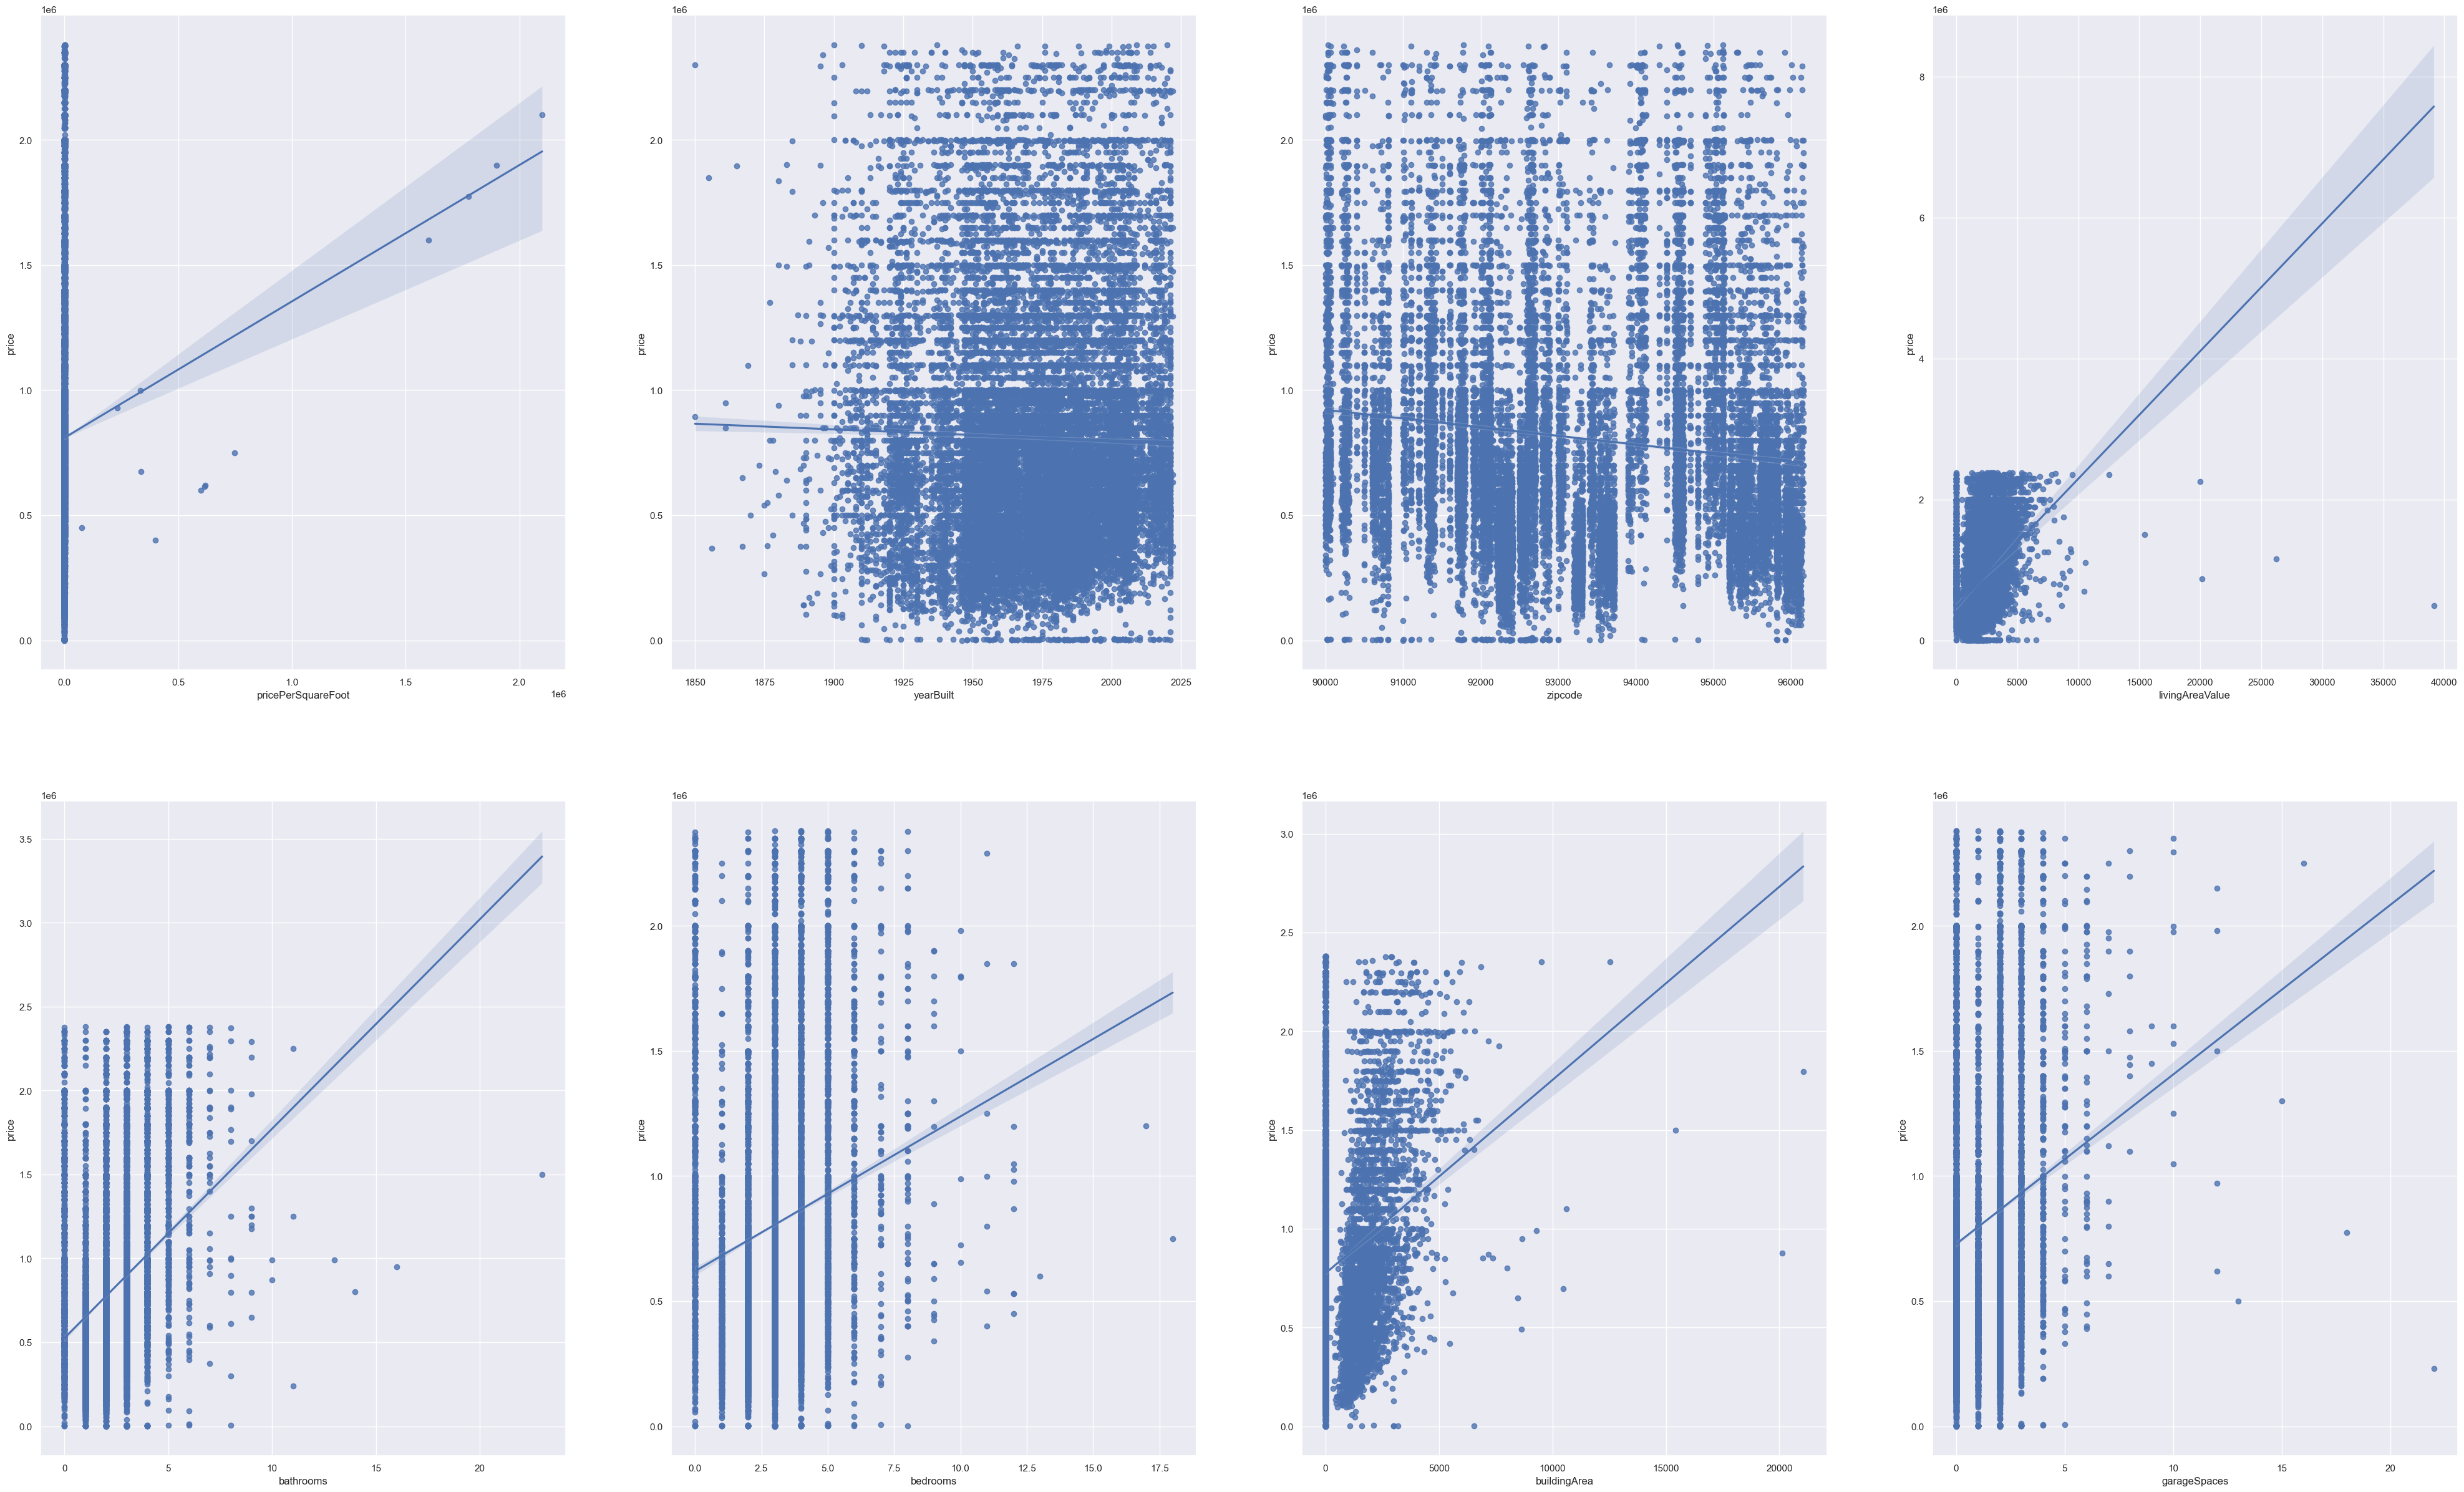

In [695]:
draw_regplots(clean_dataset,numerical_columns)

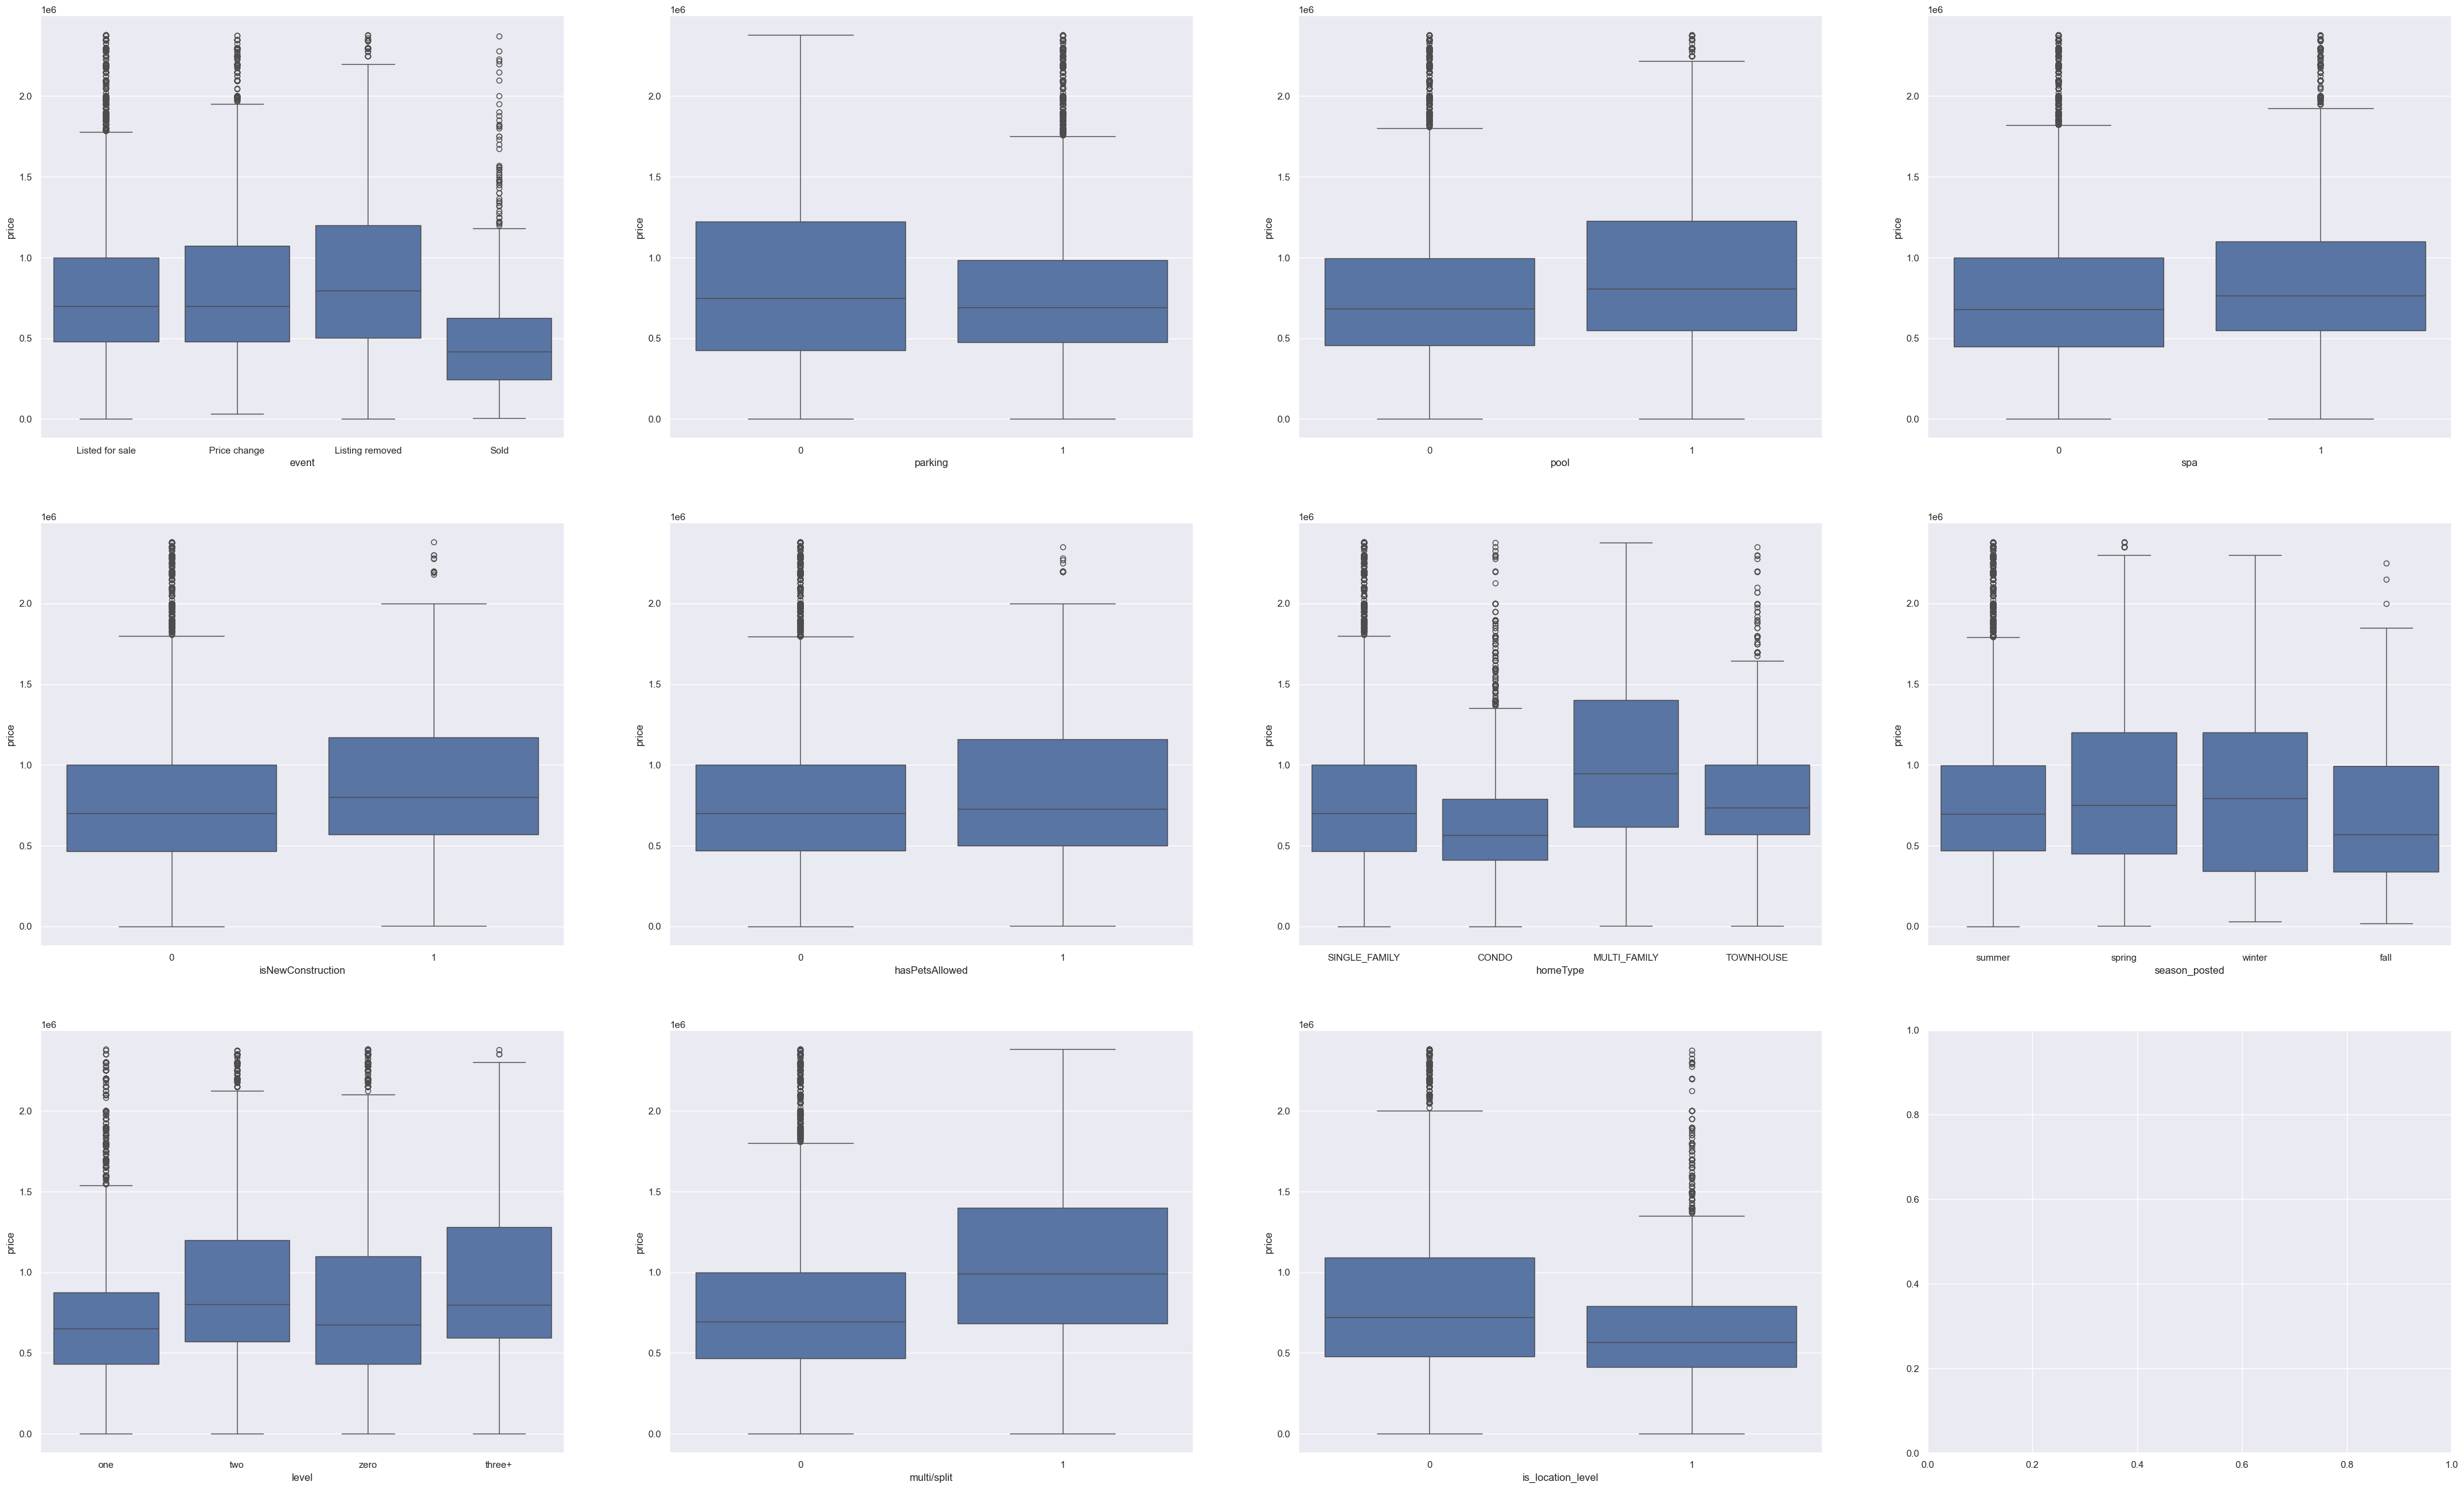

In [696]:
draw_boxplots(clean_dataset,categorical_columns)